<a href="https://colab.research.google.com/github/GarimaRay/roberta-goemotions/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install kagglehub datasets transformers accelerate evaluate scikit-learn wordcloud lime shap

import os, re, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (classification_report, f1_score, precision_score, recall_score,
                             roc_curve, auc)

import kagglehub
LABELS = [
    "admiration","amusement","anger","annoyance","approval","caring","confusion","curiosity",
    "desire","disappointment","disapproval","disgust","embarrassment","excitement","fear",
    "gratitude","grief","joy","love","nervousness","optimism","pride","realization","relief",
    "remorse","sadness","surprise","neutral"
]
NUM_LABELS = len(LABELS)

print("NUM_LABELS:", NUM_LABELS)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
NUM_LABELS: 28


In [2]:
path = kagglehub.dataset_download("debarshichanda/goemotions")
print("Path to dataset files:", path)

data_dir = Path(path)
print("Files:", [p.name for p in data_dir.glob("*")][:30])

Using Colab cache for faster access to the 'goemotions' dataset.
Path to dataset files: /kaggle/input/goemotions
Files: ['README.md', 'goemotions_model_card.pdf', 'GoEmotionsFormat.PNG', 'replace_emotions.py', 'tables', 'data', 'extract_words.py', 'calculate_metrics.py', 'plots', 'analyze_data.py']


In [3]:
path = kagglehub.dataset_download("debarshichanda/goemotions")
print("Path to dataset files:", path)

data_dir = Path(path)
print("Files:", [p.name for p in data_dir.glob("*")][:30])

Using Colab cache for faster access to the 'goemotions' dataset.
Path to dataset files: /kaggle/input/goemotions
Files: ['README.md', 'goemotions_model_card.pdf', 'GoEmotionsFormat.PNG', 'replace_emotions.py', 'tables', 'data', 'extract_words.py', 'calculate_metrics.py', 'plots', 'analyze_data.py']


In [4]:
from pathlib import Path

data_dir = Path(path)
print("DATA DIR:", data_dir)

# show all files inside (including subfolders)
all_files = list(data_dir.rglob("*"))
print("Total files found:", len(all_files))

for f in all_files[:50]:
    if f.is_file():
        print(f)


DATA DIR: /kaggle/input/goemotions
Total files found: 28
/kaggle/input/goemotions/README.md
/kaggle/input/goemotions/goemotions_model_card.pdf
/kaggle/input/goemotions/GoEmotionsFormat.PNG
/kaggle/input/goemotions/replace_emotions.py
/kaggle/input/goemotions/extract_words.py
/kaggle/input/goemotions/calculate_metrics.py
/kaggle/input/goemotions/analyze_data.py
/kaggle/input/goemotions/tables/emotion_words.csv
/kaggle/input/goemotions/data/test.tsv
/kaggle/input/goemotions/data/ekman_mapping.json
/kaggle/input/goemotions/data/dev.tsv
/kaggle/input/goemotions/data/emotions.txt
/kaggle/input/goemotions/data/train.tsv
/kaggle/input/goemotions/data/ekman_labels.csv
/kaggle/input/goemotions/data/sentiment_dict.json
/kaggle/input/goemotions/data/sentiment_mapping.json
/kaggle/input/goemotions/plots/hierarchical_corr.pdf
/kaggle/input/goemotions/plots/number_of_labels.pdf
/kaggle/input/goemotions/plots/correlations.pdf
/kaggle/input/goemotions/plots/colors.tsv
/kaggle/input/goemotions/plots/hi

In [5]:
for f in data_dir.rglob("*"):
    if f.is_file() and f.suffix.lower() in [".tsv", ".csv", ".txt"]:
        print(f)


/kaggle/input/goemotions/tables/emotion_words.csv
/kaggle/input/goemotions/data/test.tsv
/kaggle/input/goemotions/data/dev.tsv
/kaggle/input/goemotions/data/emotions.txt
/kaggle/input/goemotions/data/train.tsv
/kaggle/input/goemotions/data/ekman_labels.csv
/kaggle/input/goemotions/plots/colors.tsv
/kaggle/input/goemotions/data/full_dataset/goemotions_2.csv
/kaggle/input/goemotions/data/full_dataset/goemotions_1.csv
/kaggle/input/goemotions/data/full_dataset/goemotions_3.csv


In [6]:
for f in data_dir.rglob("*"):
    if f.is_file() and f.suffix.lower() in [".csv", ".tsv"]:
        print(f)


/kaggle/input/goemotions/tables/emotion_words.csv
/kaggle/input/goemotions/data/test.tsv
/kaggle/input/goemotions/data/dev.tsv
/kaggle/input/goemotions/data/train.tsv
/kaggle/input/goemotions/data/ekman_labels.csv
/kaggle/input/goemotions/plots/colors.tsv
/kaggle/input/goemotions/data/full_dataset/goemotions_2.csv
/kaggle/input/goemotions/data/full_dataset/goemotions_1.csv
/kaggle/input/goemotions/data/full_dataset/goemotions_3.csv


In [7]:
train_file = "/kaggle/input/goemotions/data/train.tsv"
val_file   = "/kaggle/input/goemotions/data/dev.tsv"
test_file  = "/kaggle/input/goemotions/data/test.tsv"

print(train_file, val_file, test_file)


/kaggle/input/goemotions/data/train.tsv /kaggle/input/goemotions/data/dev.tsv /kaggle/input/goemotions/data/test.tsv


In [8]:
import pandas as pd

train_df = pd.read_csv(train_file, sep="\t", header=None, names=["text", "label", "id"])
val_df   = pd.read_csv(val_file,   sep="\t", header=None, names=["text", "label", "id"])
test_df  = pd.read_csv(test_file,  sep="\t", header=None, names=["text", "label", "id"])

print("Loaded ")
print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)


Loaded 
Train: (43410, 3) Val: (5426, 3) Test: (5427, 3)


In [9]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43410 non-null  object
 1   label   43410 non-null  object
 2   id      43410 non-null  object
dtypes: object(3)
memory usage: 1017.6+ KB


,text,label,id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [10]:
# Reload train correctly (IMPORTANT)
train_df = pd.read_csv(train_file, sep="\t", header=None, names=["text", "label", "id"])

print(train_df.head())
train_df.info()


                                                text label       id
0  My favourite food is anything I didn't have to...    27  eebbqej
1  Now if he does off himself, everyone will thin...    27  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING     2  eezlygj
3                        To make her feel threatened    14  ed7ypvh
4                             Dirty Southern Wankers     3  ed0bdzj
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43410 non-null  object
 1   label   43410 non-null  object
 2   id      43410 non-null  object
dtypes: object(3)
memory usage: 1017.6+ KB


In [11]:
print(train_df["label"].head(20))
print("Example label type:", type(train_df["label"].iloc[0]))


0       27
1       27
2        2
3       14
4        3
5       26
6       15
7     8,20
8        0
9       27
10       6
11     1,4
12      27
13       5
14       3
15    3,12
16      15
17       2
18      27
19    6,22
Name: label, dtype: object
Example label type: <class 'str'>


In [12]:
def parse_labels(s):
    s = str(s).strip()
    if s == "" or s.lower() == "nan":
        return []
    return [int(x) for x in s.split(",")]

train_df["labels_list"] = train_df["label"].apply(parse_labels)

train_df[["text", "label", "labels_list"]].head(10)


,text,label,labels_list
0,My favourite food is anything I didn't have to...,27,[27]
1,"Now if he does off himself, everyone will thin...",27,[27]
2,WHY THE FUCK IS BAYLESS ISOING,2,[2]
3,To make her feel threatened,14,[14]
4,Dirty Southern Wankers,3,[3]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,26,[26]
6,Yes I heard abt the f bombs! That has to be wh...,15,[15]
7,We need more boards and to create a bit more s...,"8,20","[8, 20]"
8,Damn youtube and outrage drama is super lucrat...,0,[0]
9,It might be linked to the trust factor of your...,27,[27]


In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=list(range(NUM_LABELS)))
Y = mlb.fit_transform(train_df["labels_list"])
X = train_df["text"].astype(str).tolist()

print("X size:", len(X))
print("Y shape:", Y.shape)   # (rows, 28 labels)


X size: 43410
Y shape: (43410, 28)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Train: 34728 Val: 4341 Test: 4341


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

print(X_train_tfidf.shape)


(34728, 48480)


In [16]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
logreg = OneVsRestClassifier(
    LogisticRegression(max_iter=2000)  # max_iter increased so it converges
)
logreg.fit(X_train_tfidf, Y_train)
val_proba = logreg.predict_proba(X_val_tfidf)
test_proba = logreg.predict_proba(X_test_tfidf)

print("Probability matrix shape:", test_proba.shape)
THRESH = 0.35
Y_val_pred = (val_proba >= THRESH).astype(int)
Y_test_pred = (test_proba >= THRESH).astype(int)
micro_f1 = f1_score(Y_test, Y_test_pred, average="micro", zero_division=0)
macro_f1 = f1_score(Y_test, Y_test_pred, average="macro", zero_division=0)

micro_precision = precision_score(Y_test, Y_test_pred, average="micro", zero_division=0)
micro_recall = recall_score(Y_test, Y_test_pred, average="micro", zero_division=0)

print("\n===== Logistic Regression Results =====")
print("Threshold:", THRESH)
print("Micro F1:", micro_f1)
print("Macro F1:", macro_f1)
print("Micro Precision:", micro_precision)
print("Micro Recall:", micro_recall)


Probability matrix shape: (4341, 28)

===== Logistic Regression Results =====
Threshold: 0.35
Micro F1: 0.4774162214667314
Macro F1: 0.2428495631815078
Micro Precision: 0.6333762886597938
Micro Recall: 0.38308651597817617


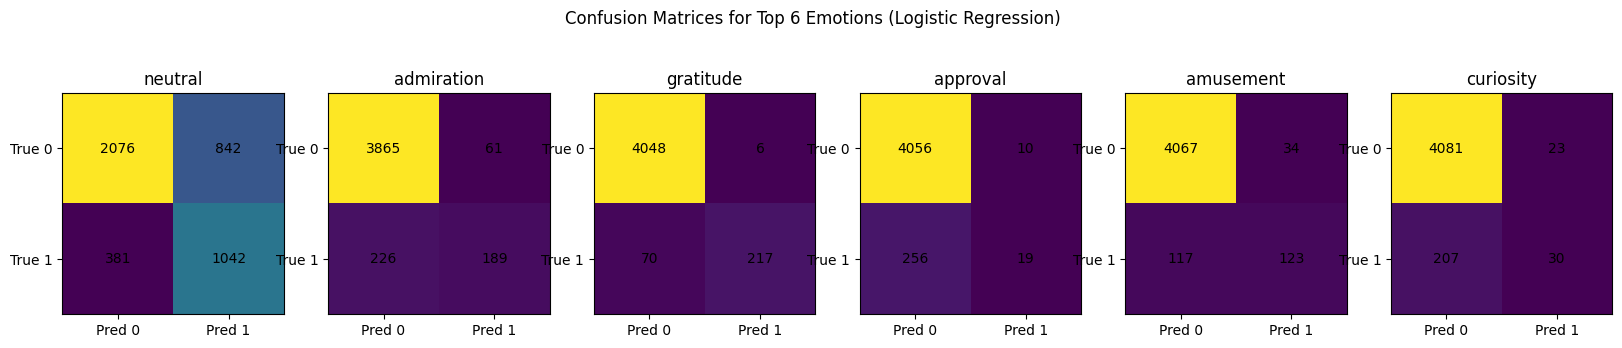

In [17]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Find top 6 most frequent emotions
label_counts = Y_test.sum(axis=0)
top_idx = np.argsort(label_counts)[::-1][:6]

mcm = multilabel_confusion_matrix(Y_test, Y_test_pred)

fig, axes = plt.subplots(1, 6, figsize=(20,4))

for ax, idx in zip(axes, top_idx):
    tn, fp, fn, tp = mcm[idx].ravel()
    matrix = [[tn, fp], [fn, tp]]

    ax.imshow(matrix)
    ax.set_title(LABELS[idx])
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])

    for i in range(2):
        for j in range(2):
            ax.text(j, i, matrix[i][j], ha="center", va="center")

plt.suptitle("Confusion Matrices for Top 6 Emotions (Logistic Regression)")
plt.show()


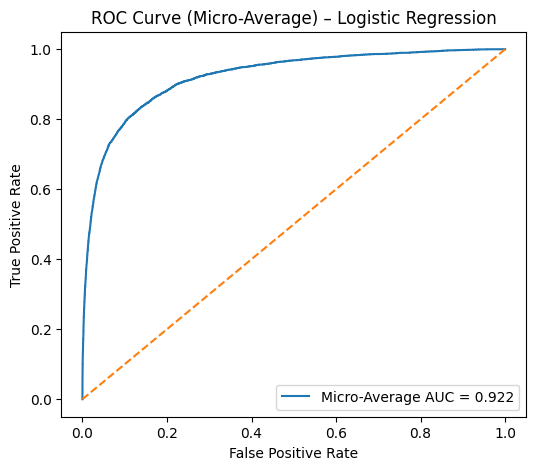

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_test.ravel(), test_proba.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Micro-Average AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Micro-Average) – Logistic Regression")
plt.legend()
plt.show()


In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score

svm = OneVsRestClassifier(LinearSVC())

svm.fit(X_train_tfidf, Y_train)

svm_scores = svm.decision_function(X_test_tfidf)   # real-valued scores
Y_test_pred_svm = (svm_scores >= 0).astype(int)    # threshold at 0 for LinearSVC

micro_f1_svm = f1_score(Y_test, Y_test_pred_svm, average="micro", zero_division=0)
macro_f1_svm = f1_score(Y_test, Y_test_pred_svm, average="macro", zero_division=0)

micro_precision_svm = precision_score(Y_test, Y_test_pred_svm, average="micro", zero_division=0)
micro_recall_svm = recall_score(Y_test, Y_test_pred_svm, average="micro", zero_division=0)

print("\n===== SVM Results =====")
print("Micro F1:", micro_f1_svm)
print("Macro F1:", macro_f1_svm)
print("Micro Precision:", micro_precision_svm)
print("Micro Recall:", micro_recall_svm)



===== SVM Results =====
Micro F1: 0.4613235107328845
Macro F1: 0.3103115125497541
Micro Precision: 0.6625319226559649
Micro Recall: 0.35385814497272017


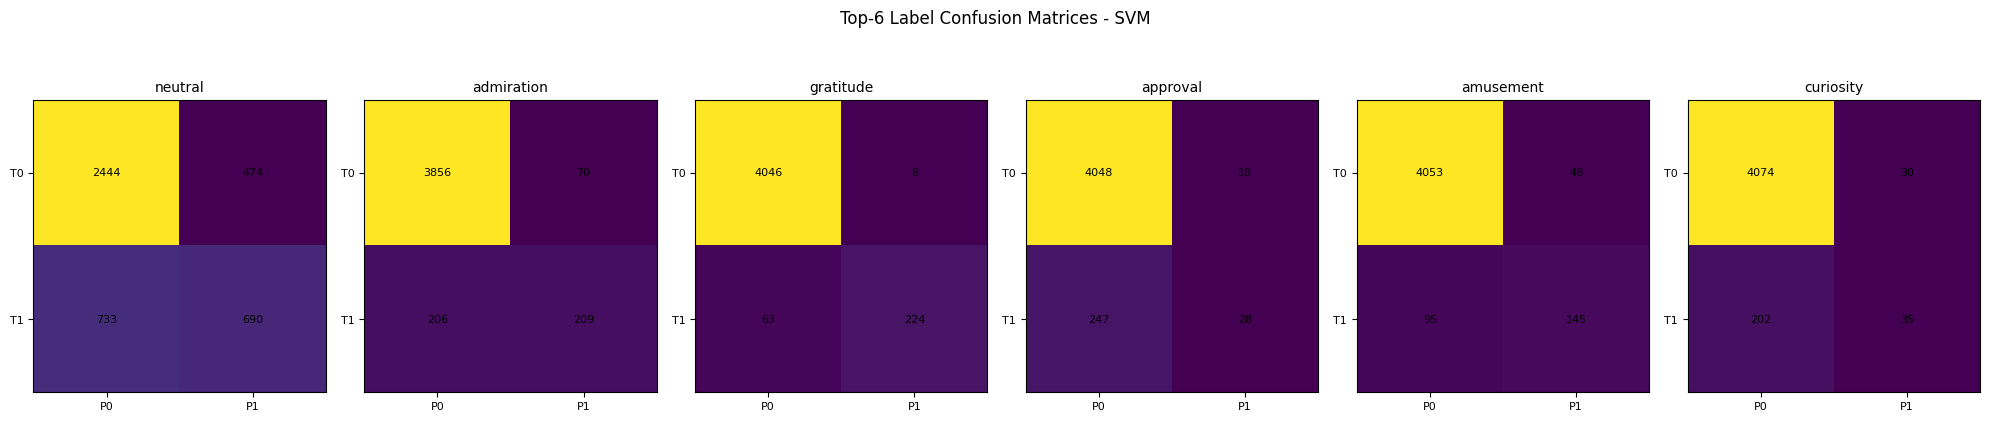

In [20]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

mcm_svm = multilabel_confusion_matrix(Y_test, Y_test_pred_svm)

label_counts = Y_test.sum(axis=0)
top_idx = np.argsort(label_counts)[::-1][:6]

fig, axes = plt.subplots(1, 6, figsize=(20,4))

for ax, idx in zip(axes, top_idx):
    tn, fp, fn, tp = mcm_svm[idx].ravel()
    mat = np.array([[tn, fp],
                    [fn, tp]])

    ax.imshow(mat)
    ax.set_title(LABELS[idx], fontsize=10)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["P0","P1"], fontsize=8)
    ax.set_yticklabels(["T0","T1"], fontsize=8)

    for (r,c), v in np.ndenumerate(mat):
        ax.text(c, r, int(v), ha="center", va="center", fontsize=8)

plt.suptitle("Top-6 Label Confusion Matrices - SVM", y=1.05)
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd

results_df = pd.DataFrame([
    {"Model":"Logistic Regression (TF-IDF)", "Micro_F1": micro_f1, "Macro_F1": macro_f1,
     "Micro_Precision": micro_precision, "Micro_Recall": micro_recall},
    {"Model":"Linear SVM (TF-IDF)", "Micro_F1": micro_f1_svm, "Macro_F1": macro_f1_svm,
     "Micro_Precision": micro_precision_svm, "Micro_Recall": micro_recall_svm},
])

results_df


,Model,Micro_F1,Macro_F1,Micro_Precision,Micro_Recall
0,Logistic Regression (TF-IDF),0.477416,0.242850,0.633376,0.383087
1,Linear SVM (TF-IDF),0.461324,0.310312,0.662532,0.353858


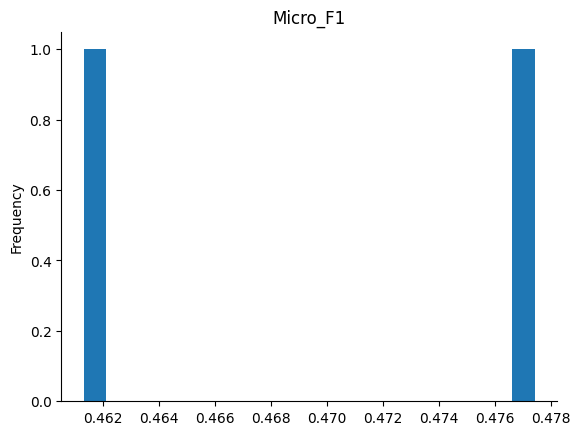

In [22]:
from matplotlib import pyplot as plt
results_df['Micro_F1'].plot(kind='hist', bins=20, title='Micro_F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [23]:
results_df.to_csv("baseline_results_lr_vs_svm.csv", index=False)
print("Saved: baseline_results_lr_vs_svm.csv")


Saved: baseline_results_lr_vs_svm.csv


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

lr_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)),
    ("clf", OneVsRestClassifier(LogisticRegression(max_iter=2000)))
])

lr_pipeline


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=2000)))])

In [25]:
from sklearn.svm import LinearSVC

svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)),
    ("clf", OneVsRestClassifier(LinearSVC()))
])

svm_pipeline


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf', OneVsRestClassifier(estimator=LinearSVC()))])

In [26]:
!pip -q install transformers datasets accelerate

import numpy as np
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score


In [27]:
print(torch.__version__)


2.9.0+cu126


In [28]:
from datasets import Dataset

# training data
hf_train = Dataset.from_dict({
    "text": X_train,
    "labels": Y_train.tolist()
})

# validation data
hf_val = Dataset.from_dict({
    "text": X_val,
    "labels": Y_val.tolist()
})

# test data
hf_test = Dataset.from_dict({
    "text": X_test,
    "labels": Y_test.tolist()
})

# Check dataset
print(hf_train)
print("\nFirst training example:")
print(hf_train[0])



Dataset({
    features: ['text', 'labels'],
    num_rows: 34728
})

First training example:
{'text': 'Wow .. this is more terrifying than if they were a ghost ! Amazing twist', 'labels': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]}


In [29]:
from transformers import AutoTokenizer

MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

hf_train_tok = hf_train.map(tokenize, batched=True)
hf_val_tok   = hf_val.map(tokenize, batched=True)
hf_test_tok  = hf_test.map(tokenize, batched=True)

# Make dataset return PyTorch tensors
hf_train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
hf_val_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
hf_test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print(hf_train_tok[0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/34728 [00:00<?, ? examples/s]

Map:   0%|          | 0/4341 [00:00<?, ? examples/s]

Map:   0%|          | 0/4341 [00:00<?, ? examples/s]

{'labels': tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0]), 'input_ids': tensor([    0, 23692, 29942,    42,    16,    55, 15567,    87,   114,    51,
           58,    10, 15934, 27785, 24361, 10619,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,  

In [30]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

print("Model loaded for multi-label classification ")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded for multi-label classification 


In [31]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

THRESH = 0.35

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs >= THRESH).astype(int)

    return {
        "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
        "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
        "micro_precision": precision_score(labels, preds, average="micro", zero_division=0),
        "micro_recall": recall_score(labels, preds, average="micro", zero_division=0),
    }

print("Metrics function ready ")


Metrics function ready 


In [32]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="roberta_goemotions",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,   # set to 2 or 3 later for better results
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="micro_f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_tok,
    eval_dataset=hf_val_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("Trainer ready ")




/tmp/ipython-input-121914691.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer ready 


In [33]:
print("labels dtype:", hf_train_tok[0]["labels"].dtype)
print("labels shape:", hf_train_tok[0]["labels"].shape)
print("num labels:", len(hf_train_tok[0]["labels"]))


labels dtype: torch.int64
labels shape: torch.Size([28])
num labels: 28


In [34]:
hf_train_tok = hf_train_tok.with_format(None)
hf_val_tok   = hf_val_tok.with_format(None)
hf_test_tok  = hf_test_tok.with_format(None)
print("Formats reset ")



Formats reset 


In [35]:
import torch

def multilabel_collator(features):

    input_ids = torch.tensor([f["input_ids"] for f in features], dtype=torch.long)
    attention_mask = torch.tensor([f["attention_mask"] for f in features], dtype=torch.long)

    labels = torch.tensor([f["labels"] for f in features], dtype=torch.float32)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }
batch_test = multilabel_collator([hf_train_tok[0], hf_train_tok[1]])
print("Batch labels dtype:", batch_test["labels"].dtype)  # must be float32


Batch labels dtype: torch.float32


In [36]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=NUM_LABELS
)
model.config.problem_type = "multi_label_classification"
print("problem_type:", model.config.problem_type)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


problem_type: multi_label_classification


In [37]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="roberta_goemotions",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="micro_f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_tok,
    eval_dataset=hf_val_tok,
    data_collator=multilabel_collator,
    compute_metrics=compute_metrics
)

print("Trainer rebuilt with custom collator ")


Trainer rebuilt with custom collator 


In [38]:
trainer.train()


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Micro Precision,Micro Recall
1,0.103400,0.100452,0.543939,0.270294,0.664498,0.460408


TrainOutput(global_step=2171, training_loss=0.12880167198971854, metrics={'train_runtime': 792.3924, 'train_samples_per_second': 43.827, 'train_steps_per_second': 2.74, 'total_flos': 2284863444688896.0, 'train_loss': 0.12880167198971854, 'epoch': 1.0})

In [39]:
print("trainer exists?", "trainer" in globals())


trainer exists? True


In [40]:
import os, glob

print("Current directory:", os.getcwd())
print("Folders here:", [f for f in os.listdir(".") if os.path.isdir(f)])

print("\nCheck roberta_goemotions contents (if exists):")
if os.path.exists("roberta_goemotions"):
    print(os.listdir("roberta_goemotions")[:50])
    print("\nCheckpoints found:", glob.glob("roberta_goemotions/checkpoint-*"))
else:
    print("roberta_goemotions folder not found in current directory")



Current directory: /content
Folders here: ['.config', 'roberta_goemotions', 'sample_data']

Check roberta_goemotions contents (if exists):
['checkpoint-2171']

Checkpoints found: ['roberta_goemotions/checkpoint-2171']


In [41]:
NUM_LABELS = 28
print("NUM_LABELS set to:", NUM_LABELS)


NUM_LABELS set to: 28


In [42]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=NUM_LABELS
)

# IMPORTANT: multi-label setup
model.config.problem_type = "multi_label_classification"

print("Model created for multi-label classification ✅")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model created for multi-label classification ✅


In [43]:
print("hf_train_tok exists?", "hf_train_tok" in globals())
print("hf_val_tok exists?", "hf_val_tok" in globals())
print("hf_test_tok exists?", "hf_test_tok" in globals())


hf_train_tok exists? True
hf_val_tok exists? True
hf_test_tok exists? True


In [44]:
print("hf_train exists?", "hf_train" in globals())
print("hf_val exists?", "hf_val" in globals())
print("hf_test exists?", "hf_test" in globals())


hf_train exists? True
hf_val exists? True
hf_test exists? True


In [45]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.preprocessing import MultiLabelBinarizer

LABELS = [
    "admiration","amusement","anger","annoyance","approval","caring","confusion","curiosity",
    "desire","disappointment","disapproval","disgust","embarrassment","excitement","fear",
    "gratitude","grief","joy","love","nervousness","optimism","pride","realization","relief",
    "remorse","sadness","surprise","neutral"
]
NUM_LABELS = len(LABELS)
print("NUM_LABELS:", NUM_LABELS)


NUM_LABELS: 28


In [46]:
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("debarshichanda/goemotions")
print("Dataset root path:", path)

data_dir = Path(path)


Using Colab cache for faster access to the 'goemotions' dataset.
Dataset root path: /kaggle/input/goemotions


In [47]:
for f in data_dir.rglob("*"):
    if f.suffix in [".tsv", ".csv"]:
        print(f)


/kaggle/input/goemotions/tables/emotion_words.csv
/kaggle/input/goemotions/data/test.tsv
/kaggle/input/goemotions/data/dev.tsv
/kaggle/input/goemotions/data/train.tsv
/kaggle/input/goemotions/data/ekman_labels.csv
/kaggle/input/goemotions/plots/colors.tsv
/kaggle/input/goemotions/data/full_dataset/goemotions_2.csv
/kaggle/input/goemotions/data/full_dataset/goemotions_1.csv
/kaggle/input/goemotions/data/full_dataset/goemotions_3.csv


In [48]:
train_file = data_dir / "data" / "train.tsv"
val_file   = data_dir / "data" / "dev.tsv"
test_file  = data_dir / "data" / "test.tsv"

import pandas as pd

train_df = pd.read_csv(train_file, sep="\t", header=None, names=["text", "label", "id"])
val_df   = pd.read_csv(val_file,   sep="\t", header=None, names=["text", "label", "id"])
test_df  = pd.read_csv(test_file,  sep="\t", header=None, names=["text", "label", "id"])

print("Shapes:", train_df.shape, val_df.shape, test_df.shape)
train_df.head()


Shapes: (43410, 3) (5426, 3) (5427, 3)


,text,label,id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [49]:
def parse_label_str(s):
    s = str(s).strip()
    if s == "":
        return []
    return [int(x) for x in s.split(",")]

train_df["labels_list"] = train_df["label"].apply(parse_label_str)
val_df["labels_list"]   = val_df["label"].apply(parse_label_str)
test_df["labels_list"]  = test_df["label"].apply(parse_label_str)

train_df[["label", "labels_list"]].head(10)


,label,labels_list
0,27,[27]
1,27,[27]
2,2,[2]
3,14,[14]
4,3,[3]
5,26,[26]
6,15,[15]
7,"8,20","[8, 20]"
8,0,[0]
9,27,[27]


In [50]:
from sklearn.preprocessing import MultiLabelBinarizer

NUM_LABELS = 28
mlb = MultiLabelBinarizer(classes=list(range(NUM_LABELS)))

Y_train = mlb.fit_transform(train_df["labels_list"])
Y_val   = mlb.transform(val_df["labels_list"])
Y_test  = mlb.transform(test_df["labels_list"])

print("Y_train shape:", Y_train.shape)
print("Example vector:", Y_train[0])


Y_train shape: (43410, 28)
Example vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [51]:
from datasets import Dataset

hf_train = Dataset.from_dict({
    "text": train_df["text"].tolist(),
    "labels": Y_train.tolist()
})

hf_val = Dataset.from_dict({
    "text": val_df["text"].tolist(),
    "labels": Y_val.tolist()
})

hf_test = Dataset.from_dict({
    "text": test_df["text"].tolist(),
    "labels": Y_test.tolist()
})

print(hf_train)
print("Example:", hf_train[0])



Dataset({
    features: ['text', 'labels'],
    num_rows: 43410
})
Example: {'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}


In [52]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

hf_train_tok = hf_train.map(tokenize_fn, batched=True)
hf_val_tok   = hf_val.map(tokenize_fn, batched=True)
hf_test_tok  = hf_test.map(tokenize_fn, batched=True)

hf_train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
hf_val_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
hf_test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print("Tokenized example:", hf_train_tok[0].keys())


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Tokenized example: dict_keys(['labels', 'input_ids', 'attention_mask'])


In [53]:
import torch

def multilabel_collator(features):
    input_ids = torch.stack([f["input_ids"] for f in features])            # ✅ stack tensors
    attention_mask = torch.stack([f["attention_mask"] for f in features])  # ✅ stack tensors
    labels = torch.stack([f["labels"] for f in features]).float()          # ✅ float32 labels

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# sanity check
batch = multilabel_collator([hf_train_tok[0], hf_train_tok[1]])
print("input_ids shape:", batch["input_ids"].shape)
print("labels dtype:", batch["labels"].dtype)


input_ids shape: torch.Size([2, 128])
labels dtype: torch.float32


In [54]:
import torch

def multilabel_collator(features):
    input_ids = torch.stack([f["input_ids"] for f in features])
    attention_mask = torch.stack([f["attention_mask"] for f in features])
    labels = torch.stack([f["labels"] for f in features]).float()

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

print("✅ Fixed collator loaded")


✅ Fixed collator loaded


In [55]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_tok,
    eval_dataset=hf_val_tok,
    data_collator=multilabel_collator,   # ✅ fixed collator
    compute_metrics=compute_metrics
)

print("✅ Trainer recreated with fixed collator")


✅ Trainer recreated with fixed collator


In [56]:
test_metrics = trainer.evaluate(hf_test_tok)

print("===== RoBERTa TEST metrics =====")
for k,v in test_metrics.items():
    if "eval_" in k:
        print(k, ":", v)


===== RoBERTa TEST metrics =====
eval_loss : 0.7078323364257812
eval_model_preparation_time : 0.0039
eval_micro_f1 : 0.07996967495340683
eval_macro_f1 : 0.07482442019603729
eval_micro_precision : 0.04165021453578668
eval_micro_recall : 1.0
eval_runtime : 32.2751
eval_samples_per_second : 168.148
eval_steps_per_second : 5.267


In [57]:
from transformers import AutoModelForSequenceClassification

NUM_LABELS = 28  # GoEmotions

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

print("Model loaded ✅")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded ✅


In [58]:
import torch

def multilabel_collator(features):
    # features = list of dicts, each has: input_ids, attention_mask, labels
    input_ids = torch.stack([f["input_ids"] for f in features])
    attention_mask = torch.stack([f["attention_mask"] for f in features])

    # IMPORTANT: multi-label uses BCEWithLogitsLoss => labels must be float
    labels = torch.stack([f["labels"] for f in features]).float()

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

print("multilabel_collator defined ✅")


multilabel_collator defined ✅


In [59]:
print("tokenizer exists?", "tokenizer" in globals())



tokenizer exists? True


In [60]:
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

NUM_LABELS = 28  # GoEmotions

def encode_labels(label_id):
    y = [0] * NUM_LABELS
    y[label_id] = 1
    return y

def tokenize_fn(batch):
    enc = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    enc["labels"] = [encode_labels(l) for l in batch["label"]]
    return enc


In [61]:
from pathlib import Path

data_dir = Path("/kaggle/input/goemotions")  # ✅ correct root

train_file = data_dir / "data" / "train.tsv"
val_file   = data_dir / "data" / "dev.tsv"
test_file  = data_dir / "data" / "test.tsv"

print(train_file)
print(val_file)
print(test_file)



/kaggle/input/goemotions/data/train.tsv
/kaggle/input/goemotions/data/dev.tsv
/kaggle/input/goemotions/data/test.tsv


In [62]:
from pathlib import Path

root = Path("/kaggle/input")
print("Folders in /kaggle/input:")
print([p.name for p in root.iterdir() if p.is_dir()])

# find train/dev/test automatically
candidates = []
for ds in root.iterdir():
    if not ds.is_dir():
        continue
    for sub in [ds, ds/"data"]:
        if (sub/"train.tsv").exists() and (sub/"dev.tsv").exists() and (sub/"test.tsv").exists():
            candidates.append(sub)

print("\n✅ Candidate data folders found:")
for c in candidates:
    print(c)


Folders in /kaggle/input:
['goemotions']

✅ Candidate data folders found:
/kaggle/input/goemotions/data


In [63]:
from pathlib import Path
import kagglehub

path = kagglehub.dataset_download("debarshichanda/goemotions")
data_root = Path(path)

print("Dataset root:", data_root)


Using Colab cache for faster access to the 'goemotions' dataset.
Dataset root: /kaggle/input/goemotions


In [64]:
for p in data_root.rglob("train.tsv"):
    print("FOUND:", p)


FOUND: /kaggle/input/goemotions/data/train.tsv


In [65]:
data_dir = p.parent   # folder containing train.tsv

train_file = data_dir / "train.tsv"
val_file   = data_dir / "dev.tsv"
test_file  = data_dir / "test.tsv"

print(train_file.exists(), val_file.exists(), test_file.exists())


True True True


In [66]:
import pandas as pd

train_df = pd.read_csv(train_file, sep="\t", header=None, names=["text", "label", "id"])
val_df   = pd.read_csv(val_file,   sep="\t", header=None, names=["text", "label", "id"])
test_df  = pd.read_csv(test_file,  sep="\t", header=None, names=["text", "label", "id"])

print("Shapes:", train_df.shape, val_df.shape, test_df.shape)
train_df.head()


Shapes: (43410, 3) (5426, 3) (5427, 3)


,text,label,id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [67]:
from datasets import Dataset

hf_train = Dataset.from_pandas(train_df)
hf_val   = Dataset.from_pandas(val_df)
hf_test  = Dataset.from_pandas(test_df)

print("HF datasets created")


HF datasets created


In [68]:
NUM_LABELS = 28

def encode_labels(label_id):
    label_id = int(label_id)   # ✅ force to int (fixes "str index" error)
    y = [0] * NUM_LABELS
    y[label_id] = 1
    return y


In [69]:
print(train_df["label"].head(5))
print(train_df["label"].dtype)
print(type(train_df["label"].iloc[0]))


0    27
1    27
2     2
3    14
4     3
Name: label, dtype: object
object
<class 'str'>


In [70]:
NUM_LABELS = 28

def encode_labels(label_str):
    y = [0] * NUM_LABELS

    # label_str could be "8,20" or "27"
    for x in str(label_str).split(","):
        x = x.strip()
        if x != "":
            y[int(x)] = 1
    return y


In [71]:
def tokenize_fn(batch):
    enc = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    enc["labels"] = [encode_labels(l) for l in batch["label"]]
    return enc


In [72]:
hf_train_tok = hf_train.map(tokenize_fn, batched=True, remove_columns=hf_train.column_names)
hf_val_tok   = hf_val.map(tokenize_fn, batched=True, remove_columns=hf_val.column_names)
hf_test_tok  = hf_test.map(tokenize_fn, batched=True, remove_columns=hf_test.column_names)

print("Tokenization done ✅")


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Tokenization done ✅


In [73]:
print(hf_train_tok[0]["labels"], len(hf_train_tok[0]["labels"]))


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 28


In [74]:
hf_train_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
hf_val_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
hf_test_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])


In [75]:
import torch

def multilabel_collator(features):
    return {
        "input_ids": torch.stack([f["input_ids"] for f in features]),
        "attention_mask": torch.stack([f["attention_mask"] for f in features]),
        "labels": torch.stack([f["labels"] for f in features]).float(),
    }


In [76]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=28)
model.config.problem_type = "multi_label_classification"


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
training_args = TrainingArguments(
    output_dir="roberta_geomotions",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=1,
    report_to="none",
)


In [78]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

THRESH = 0.5  # default threshold (we can tune later)

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # sigmoid → probabilities
    probs = 1 / (1 + np.exp(-logits))

    # threshold → binary predictions
    preds = (probs >= THRESH).astype(int)

    return {
        "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
        "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
        "micro_precision": precision_score(labels, preds, average="micro", zero_division=0),
        "micro_recall": recall_score(labels, preds, average="micro", zero_division=0),
    }


In [79]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_tok,
    eval_dataset=hf_val_tok,
    data_collator=multilabel_collator,
    compute_metrics=compute_metrics,
)


In [80]:
trainer.train()


Step,Training Loss
500,0.180900
1000,0.123100
1500,0.110400
2000,0.103600
2500,0.101200


TrainOutput(global_step=2714, training_loss=0.1218632189948153, metrics={'train_runtime': 1160.4012, 'train_samples_per_second': 37.409, 'train_steps_per_second': 2.339, 'total_flos': 2856079305861120.0, 'train_loss': 0.1218632189948153, 'epoch': 1.0})

In [81]:
trainer.evaluate(hf_test_tok)


{'eval_loss': 0.09534089267253876,
 'eval_micro_f1': 0.4736266141387612,
 'eval_macro_f1': 0.19572905583645087,
 'eval_micro_precision': 0.7703809184763261,
 'eval_micro_recall': 0.3419181545267815,
 'eval_runtime': 32.6402,
 'eval_samples_per_second': 166.267,
 'eval_steps_per_second': 5.208,
 'epoch': 1.0}

In [82]:
trainer.save_model("roberta_geomotions_final")


In [83]:
import numpy as np
from sklearn.metrics import f1_score

pred_val = trainer.predict(hf_val_tok)
logits = pred_val.predictions
y_true = pred_val.label_ids

probs = 1 / (1 + np.exp(-logits))

thresholds = np.arange(0.05, 0.95, 0.05)
best_t, best_f1 = None, -1

for t in thresholds:
    y_pred = (probs >= t).astype(int)
    f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("Best threshold:", best_t)
print("Best val micro-F1:", best_f1)


Best threshold: 0.25
Best val micro-F1: 0.576037223730128


In [84]:
THRESH = best_t


In [85]:
trainer.evaluate(hf_test_tok)


{'eval_loss': 0.09534089267253876,
 'eval_micro_f1': 0.5752934774158439,
 'eval_macro_f1': 0.33824625983781204,
 'eval_micro_precision': 0.56626874808693,
 'eval_micro_recall': 0.5846105229894138,
 'eval_runtime': 31.9815,
 'eval_samples_per_second': 169.692,
 'eval_steps_per_second': 5.316,
 'epoch': 1.0}

In [86]:
tokenizer.save_pretrained("roberta_geomotions_final")


('roberta_geomotions_final/tokenizer_config.json',
 'roberta_geomotions_final/special_tokens_map.json',
 'roberta_geomotions_final/vocab.json',
 'roberta_geomotions_final/merges.txt',
 'roberta_geomotions_final/added_tokens.json',
 'roberta_geomotions_final/tokenizer.json')

In [87]:
roberta_test_metrics = trainer.evaluate(hf_test_tok)

print("Re-evaluation done. Test metrics stored in 'roberta_test_metrics'")

Re-evaluation done. Test metrics stored in 'roberta_test_metrics'


In [88]:
roberta_metrics = {
    "Model": "RoBERTa (Transformer)",
    "Micro_F1": roberta_test_metrics["eval_micro_f1"],
    "Macro_F1": roberta_test_metrics["eval_macro_f1"],
    "Micro_Precision": roberta_test_metrics["eval_micro_precision"],
    "Micro_Recall": roberta_test_metrics["eval_micro_recall"],
}

# Ensure results_df is a DataFrame if it was not already (e.g., if previous cells were skipped)
if 'results_df' not in globals():
    results_df = pd.DataFrame([]) # Initialize an empty DataFrame if it doesn't exist

results_df = pd.concat([results_df, pd.DataFrame([roberta_metrics])], ignore_index=True)

print("Consolidated performance metrics:")
print(results_df)

Consolidated performance metrics:
                          Model  Micro_F1  Macro_F1  Micro_Precision  \
0  Logistic Regression (TF-IDF)  0.477416  0.242850         0.633376   
1           Linear SVM (TF-IDF)  0.461324  0.310312         0.662532   
2         RoBERTa (Transformer)  0.575293  0.338246         0.566269   

   Micro_Recall  
0      0.383087  
1      0.353858  
2      0.584611  


**Reasoning**:
The subtask requires visualizing the comparison of model metrics. A bar plot is suitable for this purpose, showing Micro F1, Macro F1, Micro Precision, and Micro Recall for each model.



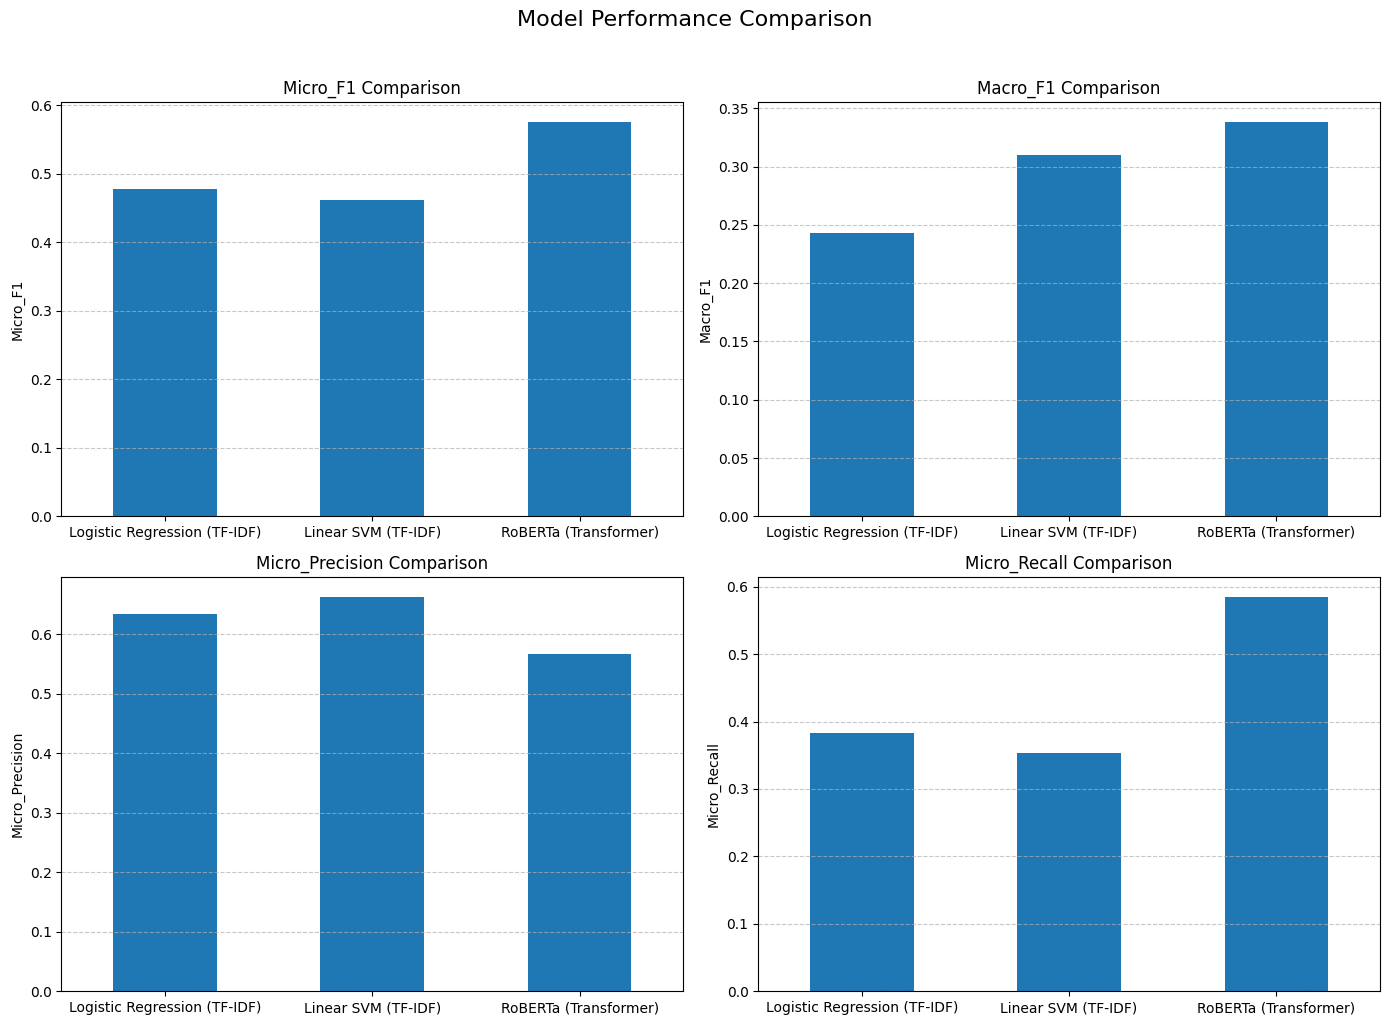

Bar chart visualization of model performance metrics displayed.


In [89]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for plotting
metrics = ['Micro_F1', 'Macro_F1', 'Micro_Precision', 'Micro_Recall']
model_names = results_df['Model']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() # Flatten for easy iteration

for i, metric in enumerate(metrics):
    ax = axes[i]
    results_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, rot=0)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Model Performance Comparison', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

print("Bar chart visualization of model performance metrics displayed.")